# Tracking

Until now we have often extracted single time points from larger datasets. However, analyzing the evolution of cells or proteins over time brings key insights into biology. It is therefore highly desirable to be able to track objects in time-lapse data. For this we need:

1. To segment objects in each frame
2. To link objects across frames

We already know how to deal with point 1 and now we are dealing with the second one. While superficially it may seem easy to link objects across time because by eye you see how they are connected, it is a non-trivial tasks for computers, especially if some objects are missing at given time points (bad segmentation) or if they can split etc.

For a start, we will here use the Trackpy package, which allows us to track particles (here nuclei over time). What it needs to do the tracking or linking is a table containing the coordinates of objects at each time point.

For this exercise, we will use a dataset available on Zenodo where HeLa cell nuclei have been imaged by fluorescence microscopy over time:

In [1]:
import skimage
from microfilm.microplot import microshow
import pandas as pd
import matplotlib.pyplot as plt

image = skimage.io.imread('../data/20210904_TL2 - R05-C03-F0.tiff')

In [2]:
image.shape

(240, 5, 540, 540)

We have 240 time points and multiple channels. At the moment we only use the last one:

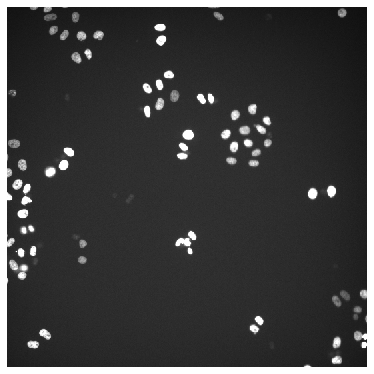

In [3]:
microshow(image[0,4], fig_scaling=5, limits=[0,10000]);

## Segmentation

To keep things simple and fast, we define a simple segmentation workflow that we will apply on each time point:
- automated thresholding
- labeling
- region measurement where we only keep the centroid
- addition of the frame information

In [4]:
mask = image[0,4] > skimage.filters.threshold_li(image[0,4])
labels = skimage.morphology.label(mask)
regions = skimage.measure.regionprops_table(labels, intensity_image=image[0,0], properties=('label', 'centroid', 'mean_intensity'))
reg = pd.DataFrame(regions)
reg['time'] = 0

In [5]:
reg

,label,centroid-0,centroid-1,mean_intensity,time
0,1,1.205882,39.735294,1346.941176,0
1,2,3.153846,60.076923,3722.051282,0
2,3,0.000000,86.500000,1296.333333,0
3,4,0.250000,309.000000,2219.666667,0
4,5,0.000000,315.000000,2320.000000,0
...,...,...,...,...,...
85,86,502.958084,494.365269,5135.011976,0
86,87,505.863905,38.852071,5194.147929,0
87,88,506.420290,535.144928,9793.333333,0
88,89,529.160000,494.286667,6661.766667,0


Above you see the output we get for a single time point. ```centroid-0``` and ```centroid-1``` represent the xy coordinates of the nuclei. We also measured the intensity in the nuclei in another channel for further analysis.

## Time-lapse segmentation

Now we apply this segmentation workflow to multiple time points in our dataset. As a start we only analyze the first 100 time points. We keep the resulting DataFrames in a list:

In [111]:
all_times = []
for i in range(100):
    mask = image[i,4] > skimage.filters.threshold_li(image[i,4])
    labels = skimage.morphology.label(mask)
    regions = skimage.measure.regionprops_table(labels, intensity_image=image[i,0], properties=('label', 'centroid', 'mean_intensity'))
    reg = pd.DataFrame(regions)
    reg['frame'] = i
    
    all_times.append(reg)

Now we can assemble all DataFrames into a single large DataFrame as required by the Trackpy package:

In [112]:
full = pd.concat(all_times)

One last thing we have to do is to change the column names for the location which should by ```x```  and ```y```:

In [113]:
nuclei_pd = full.rename(columns={'centroid-0':'x','centroid-1':'y'})

## Tracking

We can finally pass this complete DataFrame to the tracking package using the ```link_df``` function. We have several options that we can pass to the tracking function. We can choose from several algorithm (we use the default here) and specify things like "how far can objects be from frame to frame?", "in how many frames is an object allowed to be missing?" etc. Here we only set the ```search_range```:

In [114]:
import trackpy

In [115]:
traj = trackpy.link_df(nuclei_pd,search_range=10)

Frame 99: 140 trajectories present.


In [116]:
traj

,label,x,y,mean_intensity,frame,particle
0,1,1.205882,39.735294,1346.941176,0,0
66,67,351.509174,269.527523,5761.321101,0,1
64,65,331.987342,35.810127,7108.253165,0,2
63,64,309.558511,23.393617,3152.494681,0,3
62,63,289.891156,28.061224,6338.217687,0,4
...,...,...,...,...,...,...
46,47,155.291845,262.815451,2883.180258,99,462
47,48,166.116071,420.318452,3550.553571,99,76
48,49,164.881057,332.070485,2898.872247,99,386
42,43,140.736527,306.485030,4156.353293,99,595


The output that we get contains the same information as the initial table but in addition we know for each item to which track it belongs in the ```particle``` column.

Trackpy offers additional tools. For example we can remove tracks that are shorter than a certain limit e.g. 10:

In [117]:
traj_clean = trackpy.filter_stubs(traj, 10)

In [118]:
traj_clean

,label,x,y,mean_intensity,frame,particle
frame,,,,,,
0,1,1.205882,39.735294,1346.941176,0,0
0,65,331.987342,35.810127,7108.253165,0,2
0,64,309.558511,23.393617,3152.494681,0,3
0,63,289.891156,28.061224,6338.217687,0,4
0,61,279.495000,458.060000,5485.155000,0,6
...,...,...,...,...,...,...
99,47,155.291845,262.815451,2883.180258,99,462
99,48,166.116071,420.318452,3550.553571,99,76
99,49,164.881057,332.070485,2898.872247,99,386


We can also plot the trajectories:

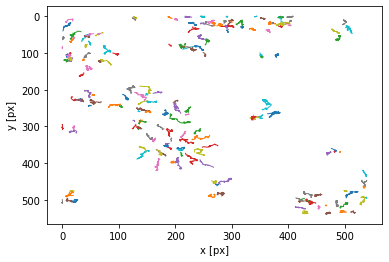

In [119]:
plt.figure()
trackpy.plot_traj(traj_clean);

We can also analyze our data. For example by measuring the mean square displacement:

In [120]:
im = trackpy.imsd(traj_clean, 0.5, 1)  # microns per pixel = 0.5, frames per second = 1

###### im

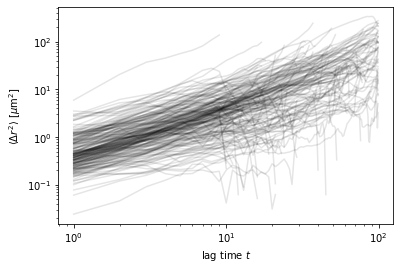

In [122]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

## napari

Finally we can also add our tracks to napari to better visualize and interact with them. For this we can add a tracks layer. The input should just be an array with dimensions ```id x frame x X x Y```, so we can just re-organize our DataFrame:

In [123]:
tacks_to_add = traj_clean[['particle', 'frame', 'x', 'y']].values#.reset_index()

In [126]:
import napari
from napari.utils import nbscreenshot

In [125]:
viewer = napari.Viewer()
viewer.add_image(image[0:100,4]);
viewer.add_tracks(tacks_to_add);

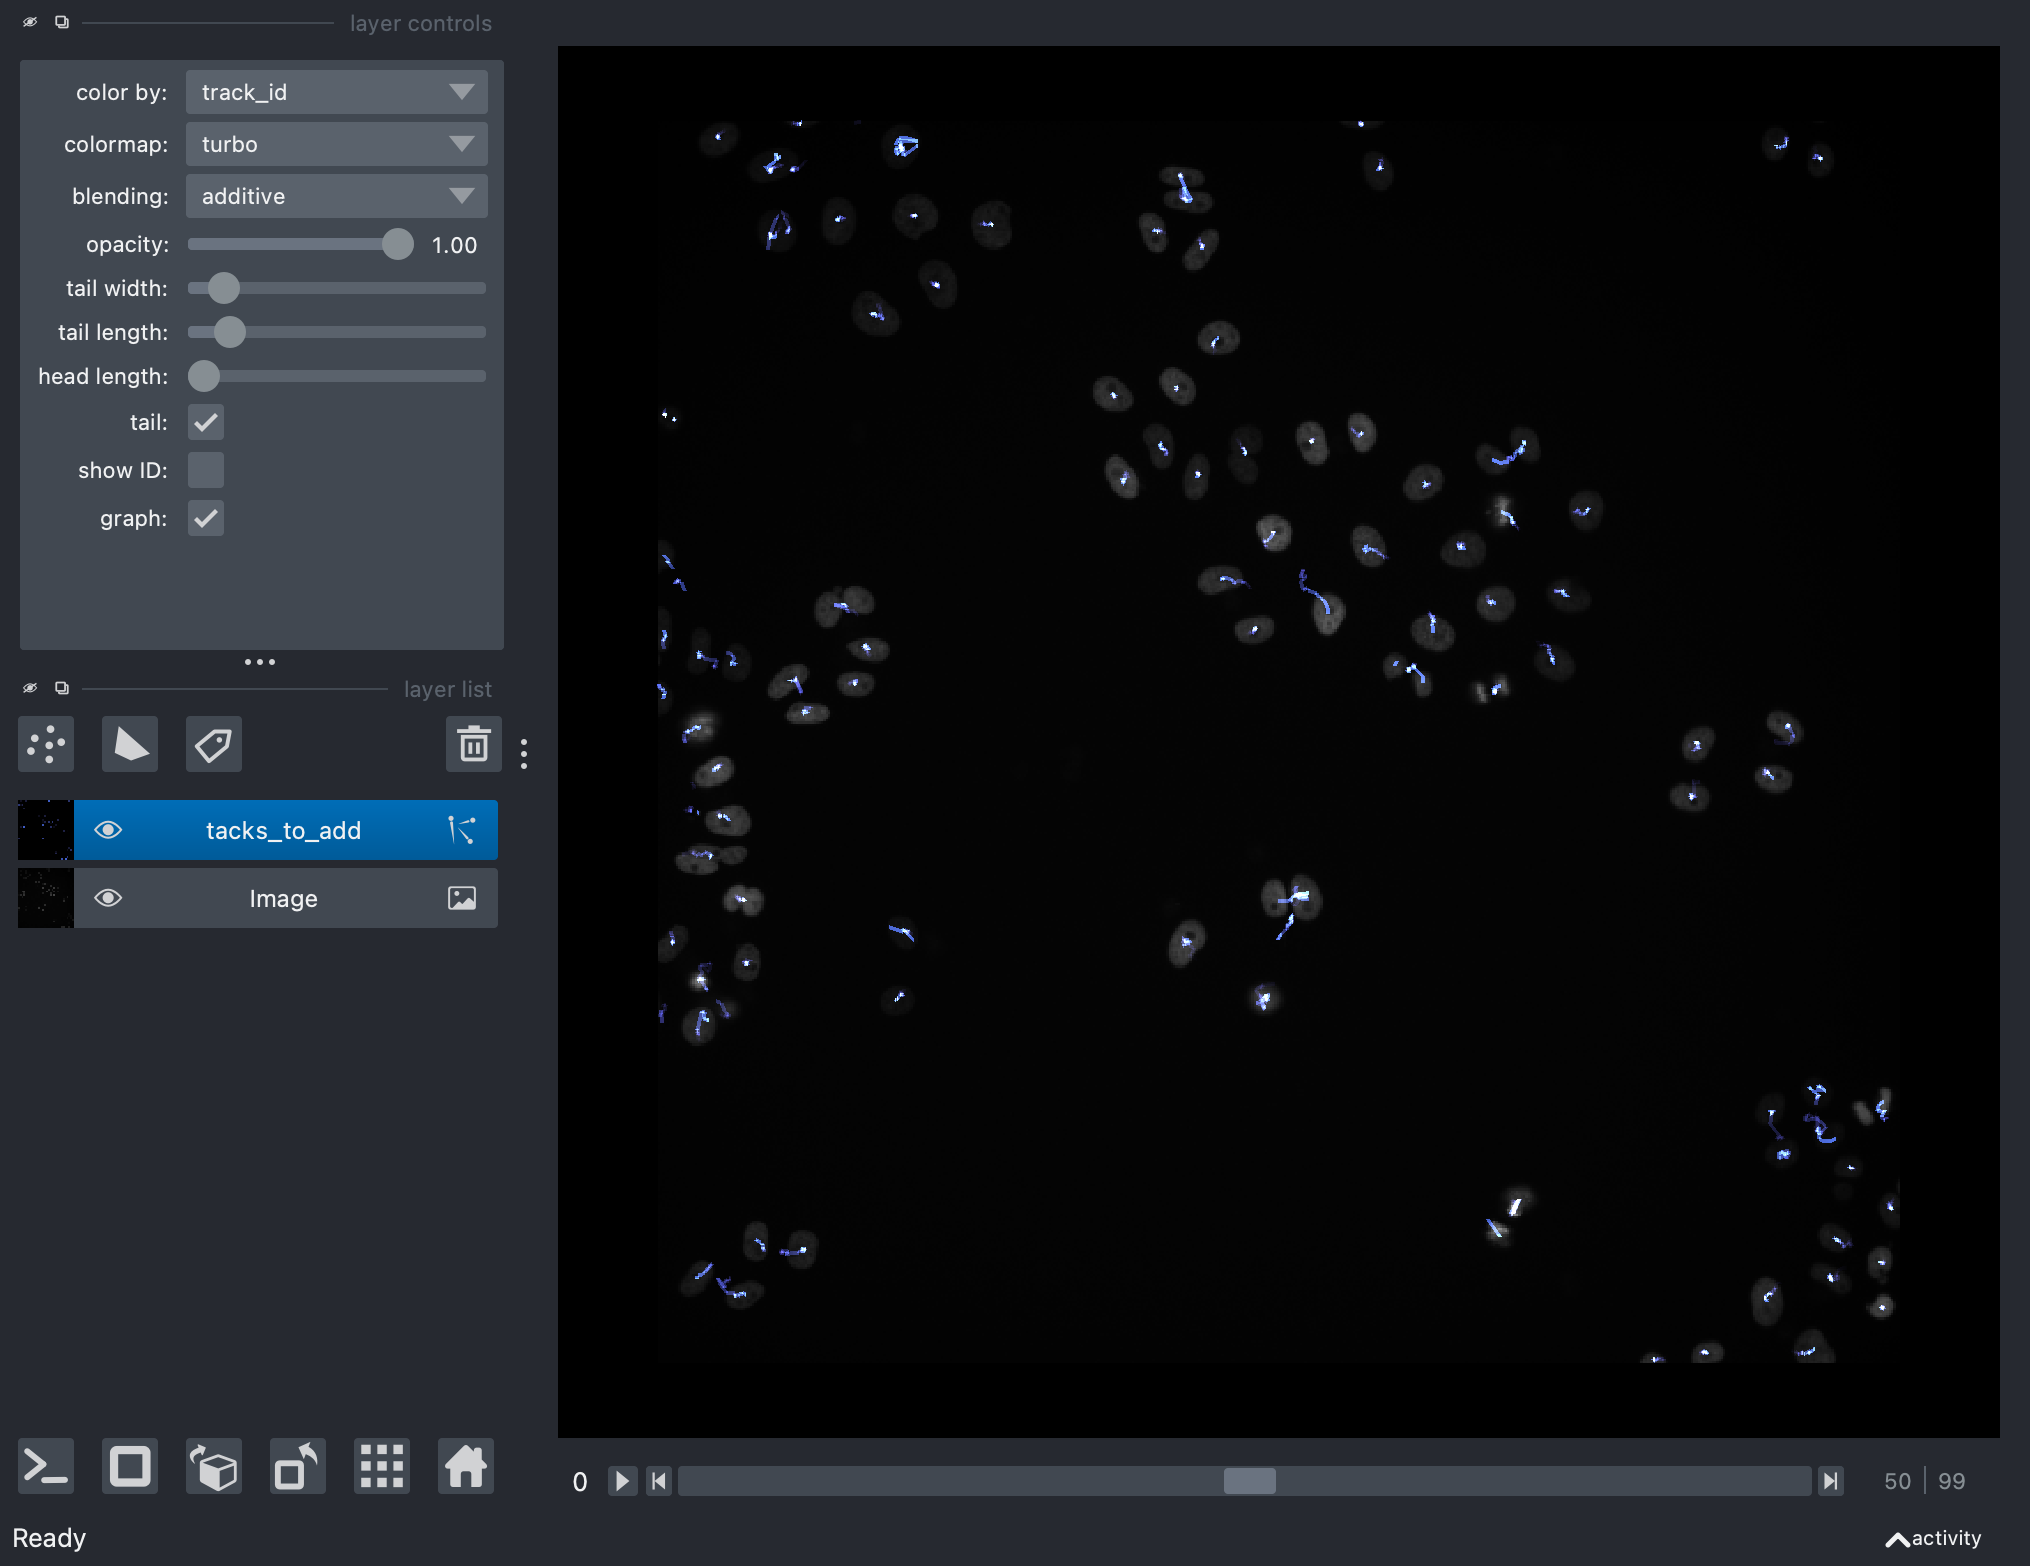

In [127]:
nbscreenshot(viewer)

Note that at the moment, our tracks are colored by ID which is not very interesting. However we can pass an additional arugment called feature, that can contain other information about the data, for example intensity in another channel:

In [129]:
viewer = napari.Viewer()
viewer.add_image(image[0:100,4]);
viewer.add_image(image[0:100,0]);
viewer.add_tracks(tacks_to_add, features=traj_clean);

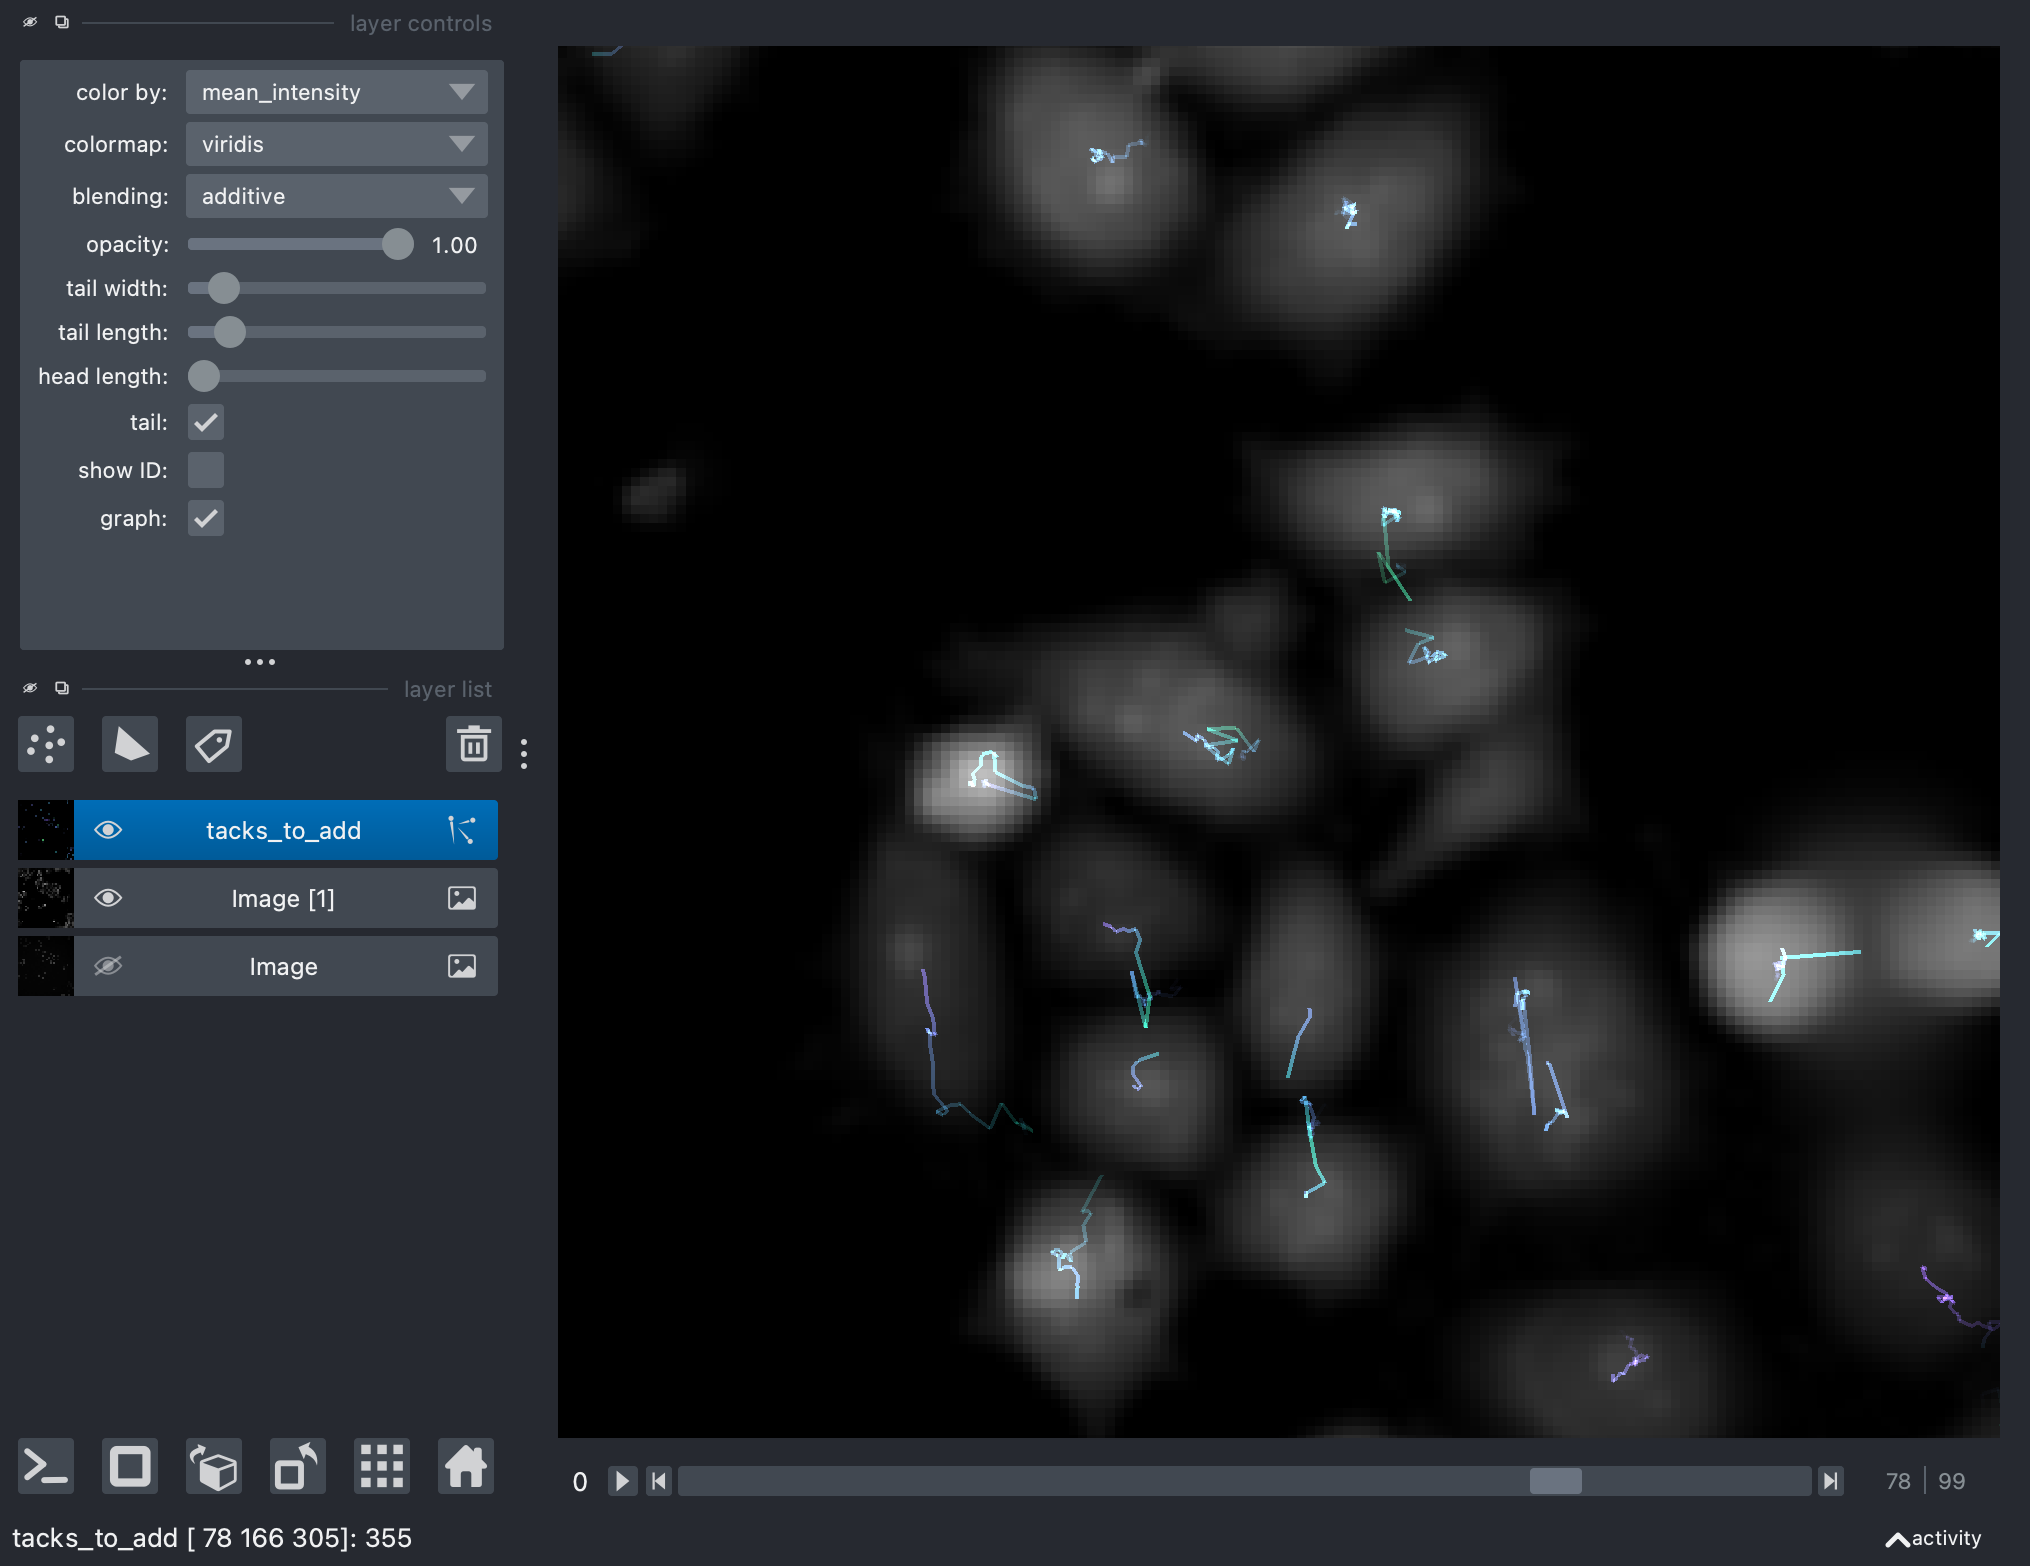

In [130]:
nbscreenshot(viewer)

## Exercise

Try to track the data that you can find in ```idr9036378_cropped.tif```. Use a projection to simplify the problem to 2D. 

In [133]:
image = skimage.io.imread('../data/idr9036378_cropped.tif')

In [134]:
image = image.max(axis=1)

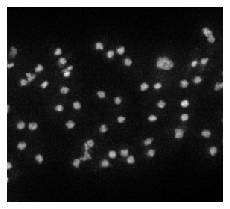

In [138]:
microshow(image[0,0]);

In [139]:
all_times = []
for i in range(image.shape[0]):
    mask = image[i,0] > skimage.filters.threshold_li(image[i,0])
    labels = skimage.morphology.label(mask)
    regions = skimage.measure.regionprops_table(labels, intensity_image=image[i,1], properties=('label', 'centroid', 'mean_intensity'))
    reg = pd.DataFrame(regions)
    reg['frame'] = i
    
    all_times.append(reg)

In [140]:
full = pd.concat(all_times)
nuclei_pd = full.rename(columns={'centroid-0':'x','centroid-1':'y'})
traj = trackpy.link_df(nuclei_pd,search_range=10)

Frame 13: 67 trajectories present.


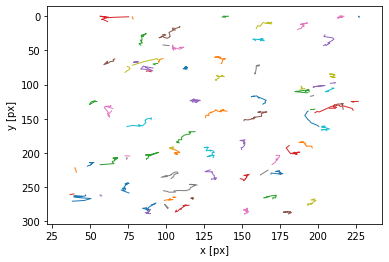

In [142]:
plt.figure()
trackpy.plot_traj(traj);